In [1]:
import zipfile
import numpy as np
import pandas as pd
import gzip
import shutil
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as colors
from scipy.stats import gaussian_kde

In [2]:
#Open main objects generated below
#OP_df=pd.read_pickle("./OP16_df.pkl")
OP_df_refprot_ms0=pd.read_pickle("./OP16_df_refprot_ms0.pkl")
OP_df_altprot_ms0=pd.read_pickle("./OP16_df_altprot_ms0.pkl")
MART_df=pd.read_pickle("./MART95_df.pkl")
MART_df_psdg=pd.read_pickle("./MART95_df_psdg.pkl")
OP_df_altprot_ms0_psdg=pd.read_pickle("./OP16_df_altprot_ms0_psdg.pkl")
OP_df_refprot_ms0_len300=pd.read_pickle("./OP16_df_refprot_ms0_len300.pkl")
OP_df_altprot_ms0_psdg_lngstorf=pd.read_pickle("./OP_df_altprot_ms0_psdg_lngstorf")
OP_df_altprot_ms0_psdg_lngstorf_len300=pd.read_pickle("./OP_df_altprot_ms0_psdg_lngstorf_len300")

In [4]:
#Path to unfiltered OpenProt .tsv file version 1.6
#https://archive.openprot.org/p/download
OP_file="human-openprot-r1_6-refprots+altprots+isoforms-+uniprot2019_03_01.tsv"

In [3]:
#Unarchive OP_file
with zipfile.ZipFile(f'{OP_file}.zip', 'r') as zip_ref:
    zip_ref.extractall("./")

In [8]:
#Load OP_file
OP_df=pd.read_csv(OP_file,sep="\t",skiprows=[0])

C:\Users\Lera\AppData\Local\Temp\ipykernel_6584\4042716307.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  OP_df=pd.read_csv(OP_file,sep="\t",skiprows=[0])


In [11]:
#Extract only reference (canonical) proteins. _ms0 indicates no filtering on MS score
OP_df_refprot_ms0=OP_df.loc[(OP_df["protein type"]=="RefProt"),]

In [12]:
#Extract only alternative proteins
OP_df_altprot_ms0=OP_df.loc[(OP_df["protein type"]=="AltProt"),] 

In [21]:
#BioMart query of Ensemble 95 (compatible with Openprot v1.6)
#https://jan2019.archive.ensembl.org/biomart/martview/dace2a612a1691831d9f86d3c6c0e59c
MART_file="./mart95_export.txt" 

In [22]:
#Unarchive MART_file
with gzip.open(f'{MART_file}.gz', 'rb') as f_in:
    with open(MART_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [23]:
#Load MART_file
MART_df=pd.read_csv(MART_file,sep="\t")

In [25]:
#Extract only pseudogenes
psdg_ind_mart=[i for x,i in zip(list(MART_df["Gene type"]),list(MART_df.index)) if "pseudogene" in x]
MART_df_psdg=MART_df.iloc[psdg_ind_mart,:]

In [29]:
MART_psdg_trxlist=list(MART_df_psdg["Transcript stable ID"])

In [28]:
#Extract stable transcript id
OP_df_altprot_ms0["id"]=pd.DataFrame(OP_df_altprot_ms0['transcript accession'].apply(lambda x: x.split(".")[0]))

C:\Users\Lera\AppData\Local\Temp\ipykernel_6584\1683176474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OP_df_altprot_ms0["id"]=pd.DataFrame(OP_df_altprot_ms0['transcript accession'].apply(lambda x: x.split(".")[0]))


In [30]:
#Leave only pseudogenic alternative proteins
OP_df_altprot_ms0_psdg=OP_df_altprot_ms0[OP_df_altprot_ms0['id'].isin(MART_psdg_trxlist)]

In [13]:
#Select pseudogenic proteins with longest ORF by transcript coordinates
OP_df_altprot_ms0_psdg_lngstorf=pd.DataFrame(columns=OP_df_altprot_ms0_psdg.columns)
for psdg in set(list(OP_df_altprot_ms0_psdg['gene symbol'])):
    df=OP_df_altprot_ms0_psdg.loc[OP_df_altprot_ms0_psdg['gene symbol']==psdg,]
    orflen=list(df['stop transcript coordinates']-df['start transcript coordinates'])
    maxorfidx=orflen.index(np.max(orflen))
    df=df.iloc[maxorfidx,:].to_frame().transpose()
    OP_df_altprot_ms0_psdg_lngstorf=pd.concat([OP_df_altprot_ms0_psdg_lngstorf,df])

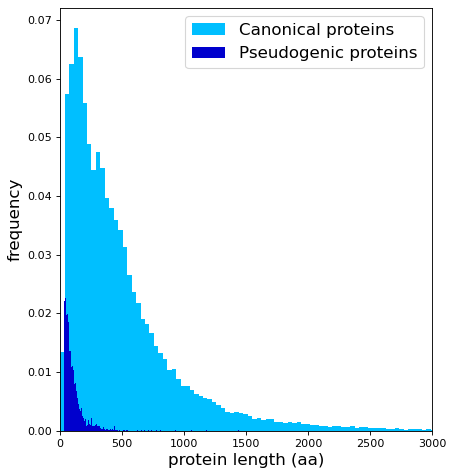

In [6]:
#Build frequency histogram of protein length
figure(figsize=(6, 7), dpi=80)
plt.hist(list(OP_df_refprot_ms0['protein length (a.a.)']),bins=1000,color="deepskyblue",weights=np.zeros_like(list(OP_df_refprot_ms0['protein length (a.a.)'])) + 1. / len(list(OP_df_refprot_ms0['protein length (a.a.)'])));
plt.hist(list(OP_df_altprot_ms0_psdg_lngstorf['protein length (a.a.)']),bins=1000,color="mediumblue",weights=np.zeros_like(list(OP_df_altprot_ms0_psdg_lngstorf['protein length (a.a.)'])) + 1. / len(list(OP_df_altprot_ms0_psdg_lngstorf['protein length (a.a.)'])));
plt.xlim(0,3000);
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("frequency",size=15);
plt.xlabel("protein length (aa)",size=15);
plt.legend(["Canonical proteins","Pseudogenic proteins"],prop={'size': 15});
plt.savefig("freq_protlen4.png");

In [39]:
#Select canonical proteins with protein length < 300 aa
OP_df_refprot_ms0_len300=OP_df_refprot_ms0.loc[OP_df_refprot_ms0['protein length (a.a.)']<300,]

In [7]:
f"Percent of canonical proteins with protein length < 300 aa = {(len(OP_df_refprot_ms0_len300)/len(OP_df_refprot_ms0)*100)}%"

'Percent of canonical proteins with protein length < 300 aa = 42.826223915587%'

In [43]:
x=list(OP_df_refprot_ms0_len300['protein length (a.a.)'])
y=list(OP_df_refprot_ms0_len300['MS score'])
# Calculate the point density, maight take a while
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

In [40]:
#Set cmap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('jet')
new_cmap = truncate_colormap(cmap, 0.32, 0.3)

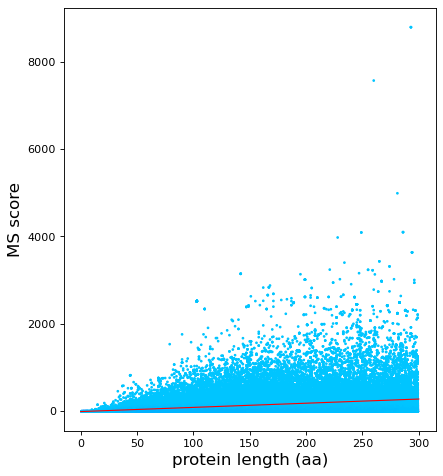

In [42]:
#Density dot plot displays corelation between protein length and MS score (sum of unique peptide per study)
figure(figsize=(6, 7), dpi=80)
plt.scatter(x, y,c=z,s=2,cmap=new_cmap)
zz = np.polyfit(x, y, 1)
p = np.poly1d(zz)
p1_y=np.min(p(x))
p2_y=np.max(p(x))
x_values = [0, 300]
y_values = [p1_y, p2_y]
plt.plot(x_values, y_values, 'r', linestyle="-",linewidth=1);
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("MS score",size=15);
plt.xlabel("protein length (aa)",size=15);
plt.savefig("ms_protlen5.png");

In [9]:
#Select pseudogenic proteins with protein length < 300 aa
OP_df_altprot_ms0_psdg_lngstorf_len300=OP_df_altprot_ms0_psdg_lngstorf.loc[OP_df_altprot_ms0_psdg_lngstorf['protein length (a.a.)']<300,]

In [16]:
f"Percent of pseudogenic proteins with protein length < 300 aa = {len(OP_df_altprot_ms0_psdg_lngstorf_len300)/len(OP_df_altprot_ms0_psdg_lngstorf)}%"

'Percent of pseudogenic proteins with protein length < 300 aa = 0.9671824519639517%'

C:\Users\Lera\AppData\Local\Temp\ipykernel_15516\3668338568.py:2: RuntimeWarning: divide by zero encountered in log
  my_dict3 = {'Canonical proteins': np.log(list(OP_df_refprot_ms0_len300['MS score'])), 'Pseudogenic proteins': list(np.log(list(OP_df_altprot_ms0_psdg_lngstorf_len300['MS score'])))}


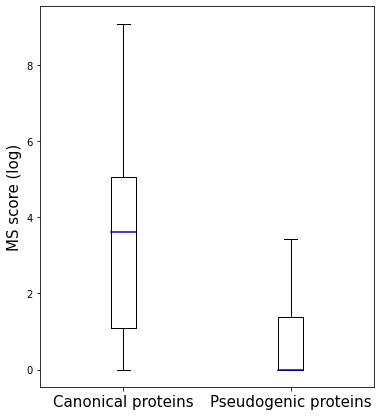

In [3]:
#Boxplot shows MS score of canonical and pseudogenic proteins of length <300 aa. Outliers are hidden for canonical proteins
my_dict3 = {'Canonical proteins': np.log(list(OP_df_refprot_ms0_len300['MS score'])), 'Pseudogenic proteins': list(np.log(list(OP_df_altprot_ms0_psdg_lngstorf_len300['MS score'])))}
my_dict3['Pseudogenic proteins'].sort()
my_dict3['Pseudogenic proteins']=my_dict3['Pseudogenic proteins'][8971:] #remove -inf so the data can be ploted
fig, ax = plt.subplots()
ax.boxplot(my_dict3.values(),labels=my_dict3.keys(),showfliers=False,medianprops = dict(color = "mediumblue", linewidth = 1.5)) #outliers hidden
plt.ylabel("MS score (log)",size=15);
ax.tick_params(axis='x', labelsize=15)
fig = plt.gcf()
fig.set_size_inches(6, 7)
plt.savefig("ms_refalt5.png");

In [14]:
#save main objects
#OP_df.to_pickle("./OP16_df.pkl")
#OP_df_refprot_ms0.to_pickle("./OP16_df_refprot_ms0.pkl")
#OP_df_altprot_ms0.to_pickle("./OP16_df_altprot_ms0.pkl")
#MART_df.to_pickle("./MART95_df.pkl")
#MART_df_psdg.to_pickle("./MART95_df_psdg.pkl")
#OP_df_altprot_ms0_psdg.to_pickle("./OP16_df_altprot_ms0_psdg.pkl")
#OP_df_refprot_ms0_len300.to_pickle("./OP16_df_refprot_ms0_len300.pkl")
#OP_df_altprot_ms0_psdg_lngstorf.to_pickle("./OP_df_altprot_ms0_psdg_lngstorf")
#OP_df_altprot_ms0_psdg_lngstorf_len300.to_pickle("./OP_df_altprot_ms0_psdg_lngstorf_len300")